In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context = 'talk', font_scale = 1.05)

# Set a hashed-line function:
def abline(slope, intercept, style, color):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, style, color = color)

In [2]:
# Load Data
data = pd.read_csv('processed_data_I.csv')
data.drop(['Unnamed: 0', 'Country Code', 'Year'], axis = 1, inplace = True)
country_list = pd.read_excel('constraints.xlsx', sheet_name = 'country-code')

# Add country names
data = pd.merge(left = country_list,
                right = data,
                on = 'iso_a3')

# Update numerical columns as percentages
data['big_mac_index'] = data['big_mac_index']*100
data['labor comp per capita'] = data['labor comp per capita']*100 
data['big_mac_affordability'] = (data['GDP per capita'] / data['dollar_price']) / 365

**Descriptive Statistics of variables**

In [3]:
cols = ['big_mac_index', 'GDP per capita', 'Curr Acc Balance', 'GGB', 'labor comp per capita']
data.describe()[cols]

,big_mac_index,GDP per capita,Curr Acc Balance,GGB,labor comp per capita
count,357.000000,357.000000,340.000000,357.000000,357.000000
mean,-10.245314,27097.617453,0.194638,-1.974667,55.449663
std,31.391388,13928.559769,4.652832,3.212204,6.927827
min,-66.471723,2920.560791,-9.874720,-13.099931,35.892659
25%,-34.959293,14297.221390,-3.122691,-3.897100,52.159649
50%,-13.822278,27533.737340,-0.779443,-1.953151,56.169033
75%,4.916213,37499.525130,3.111119,0.202036,59.515077
max,98.352166,68105.154980,17.474242,7.739158,70.999104


**Big Mac Valuation**

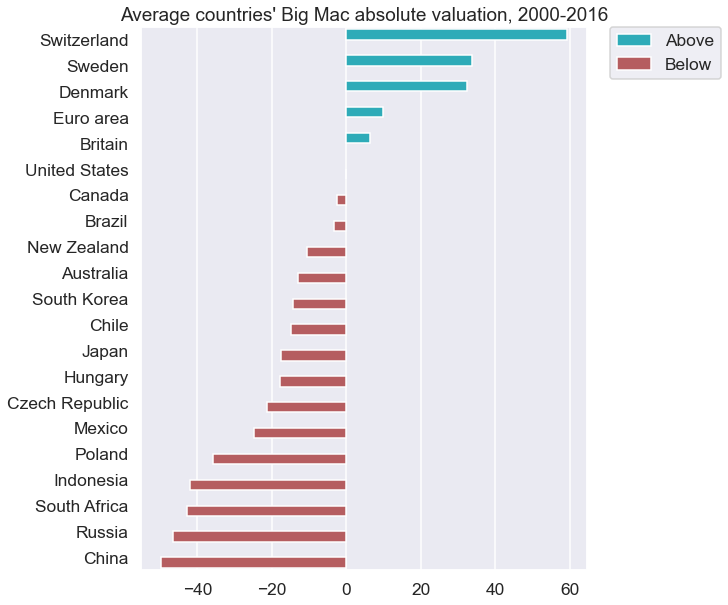

In [4]:
avg_across_years = data.groupby(by = ['iso_a3','name'], as_index = False).agg({'big_mac_index': 'mean',
                                                                               'labor comp per capita': 'mean',
                                                                               'Curr Acc Balance': 'mean',
                                                                               'GGB': 'mean',
                                                                               'big_mac_affordability': 'mean'})
avg_across_years['over'] = avg_across_years['big_mac_index'].apply(lambda x: 'Above' if x > 0 else 'Below')


# Plot Big Mac Average Valudation for all countries
fig = plt.figure(figsize = (8, 10))
sns.barplot(data = avg_across_years.sort_values(by = 'big_mac_index', ascending = False), 
            x = 'big_mac_index', 
            y = 'name',
            hue = 'over',
            palette = dict({'Above': 'tab:cyan', 'Below': 'r'}))

plt.ylabel('')
plt.xlabel('')
plt.title("Average countries' Big Mac absolute valuation, 2000-2016")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

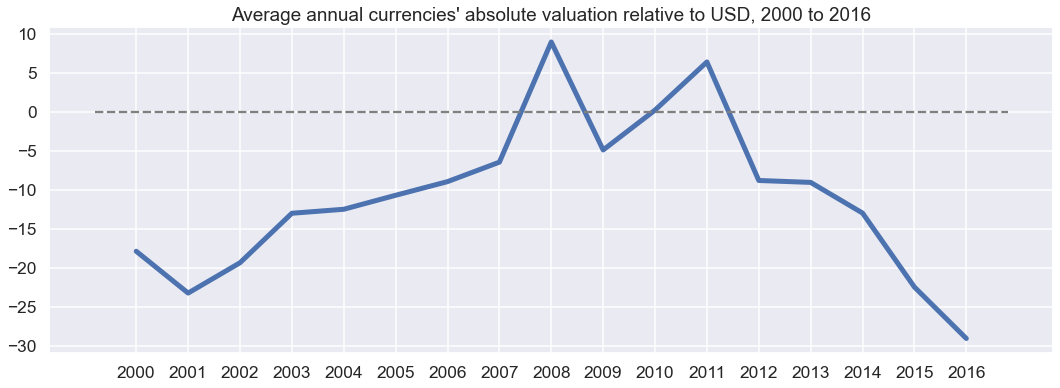

In [5]:
avg_across_country = data.loc[data['iso_a3'] != 'USA'].groupby(by = ['year'], 
                                                               as_index = False).agg({'big_mac_index': 'mean',
                                                                        'labor comp per capita': 'mean',
                                                                        'Curr Acc Balance': 'mean',
                                                                        'GGB': 'mean',
                                                                        'big_mac_affordability': 'mean'})

# Plot Big Mac Average Valuation across years
fig = plt.figure(figsize = (18, 6))
g = sns.lineplot(data = avg_across_country.sort_values(by = 'year', ascending = True), 
                 x = 'year', 
                 y = 'big_mac_index',
                 linewidth = 5)
abline(0, 0, '--', 'grey')

g.set(title = "Average annual currencies' absolute valuation relative to USD, 2000 to 2016", 
      xlabel = '', ylabel = '', 
      xticks = avg_across_country['year'].tolist())
#plt.xticks(rotation=90)

plt.show()

**Big mac Affordability**

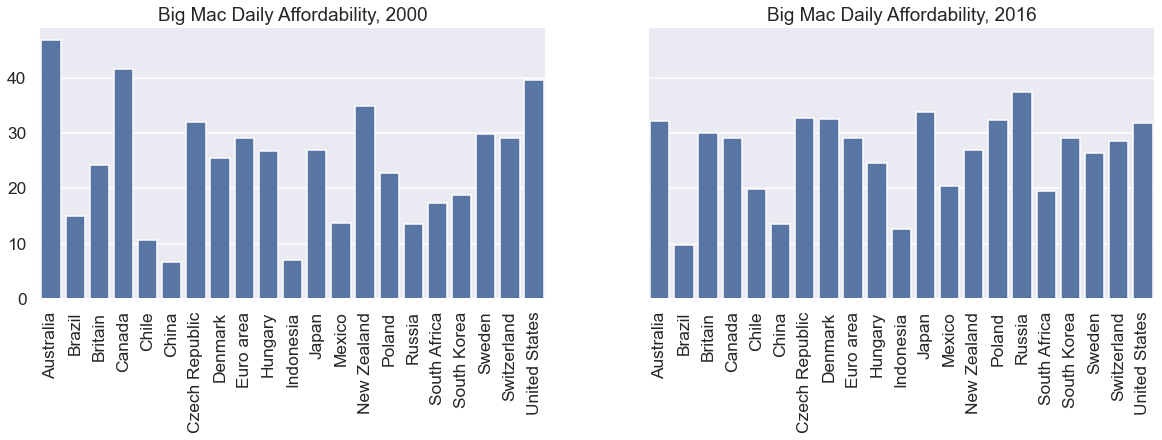

In [6]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, sharey = True, figsize = (20, 5))

plt.sca(ax[0])
sns.barplot(data = data.loc[data['year'] == 2000], 
            y = 'big_mac_affordability', 
            x = 'name',
            color = 'b').set(title = 'Big Mac Daily Affordability, 2000', xlabel = '', ylabel = '')
plt.xticks(rotation=90)

plt.sca(ax[1])
sns.barplot(data = data.loc[data['year'] == 2016], 
            y = 'big_mac_affordability', 
            x = 'name',
            color = 'b').set(title = 'Big Mac Daily Affordability, 2016', xlabel = '', ylabel = '')
plt.xticks(rotation=90)

plt.show()

**Big Mac Index - Data Exploration**

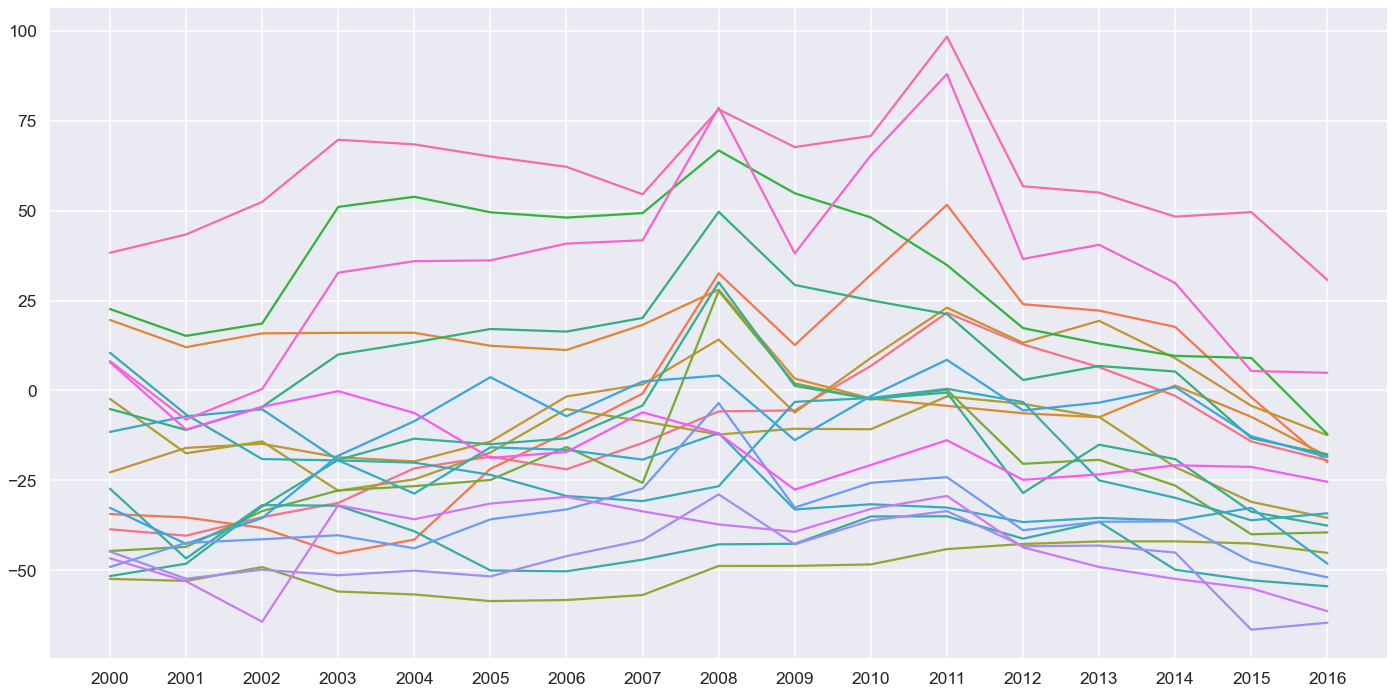

In [70]:
fig = plt.figure(figsize = (24,12))

sns.lineplot(data = data.loc[data['iso_a3'] != 'USA'], x = 'year', y = 'big_mac_index',
             hue = 'name').set(xlabel = '', ylabel = '', xticks = data['year'].drop_duplicates().tolist())
plt.legend([],[], frameon=False)
plt.show()

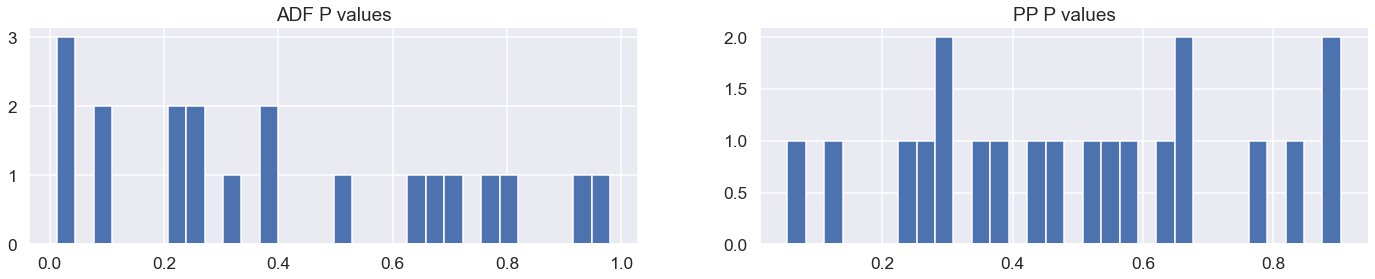

In [71]:
import arch.unitroot as at
import statsmodels.tsa.stattools as st
import statsmodels.graphics.tsaplots as tsaplots

# Perform Augmented Dickey Fuller & PP Unit Root Tests for Stationarity

df = data.loc[data['iso_a3'] != 'USA']

adf_pval, pp_pval = [], []
for country in df['name'].drop_duplicates():
    adf = st.adfuller(x = df.loc[data['name'] == country, 'big_mac_index'])
    pp = at.PhillipsPerron(y = df.loc[df['name'] == country, 'big_mac_index'])
    adf_pval.append(adf[1])
    pp_pval.append(pp.pvalue)
    
# Plot Histogram
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (24, 4))
plt.sca(ax[0])
plt.hist(adf_pval, bins = 30)
plt.title('ADF P values')
plt.sca(ax[1])
plt.hist(pp_pval, bins = 30)
plt.title('PP P values')
plt.show()

**Except 1-2 countries, the big_mac_index of all other countries do not appear stationary.**

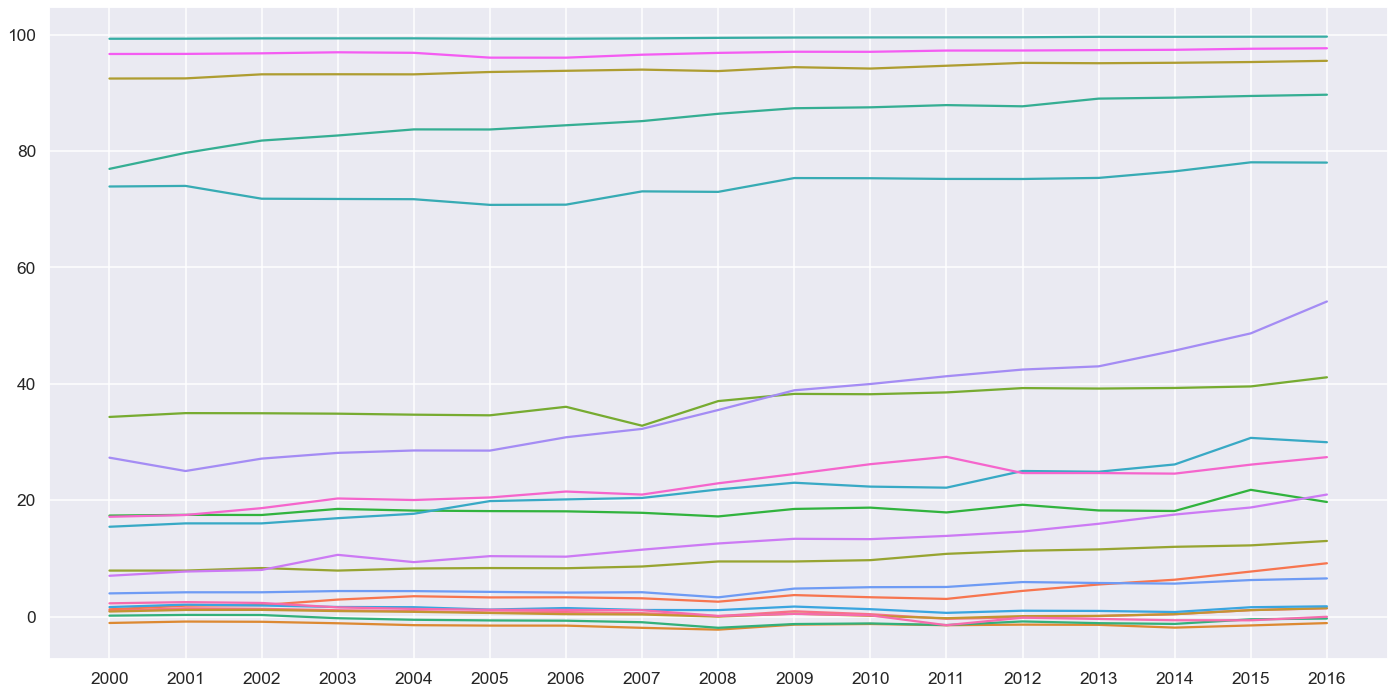

In [72]:
fig = plt.figure(figsize = (24,12))

sns.lineplot(data = data.loc[data['iso_a3'] != 'USA'], x = 'year', y = 'relative_PPP',
             hue = 'name').set(xlabel = '', ylabel = '', xticks = data['year'].drop_duplicates().tolist())
plt.legend([],[], frameon=False)
plt.show()

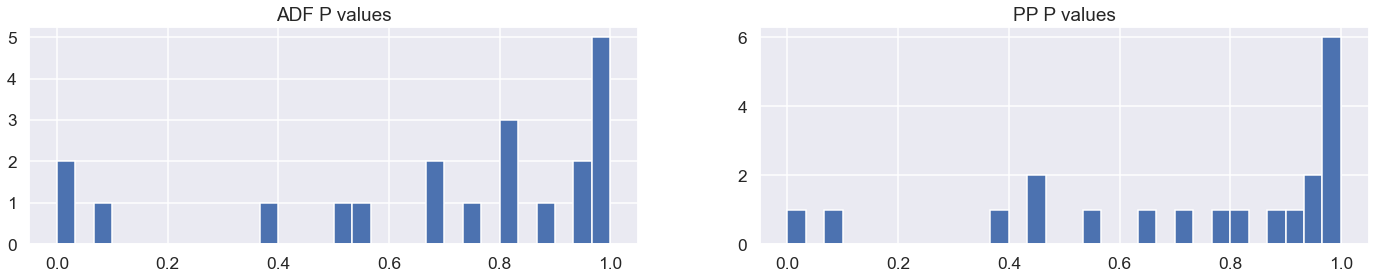

In [74]:
# Perform Augmented Dickey Fuller & PP Unit Root Tests for Stationarity

adf_pval, pp_pval = [], []
for country in df['name'].drop_duplicates():
    adf = st.adfuller(x = df.loc[data['name'] == country, 'relative_PPP'])
    pp = at.PhillipsPerron(y = df.loc[df['name'] == country, 'relative_PPP'])
    adf_pval.append(adf[1])
    pp_pval.append(pp.pvalue)
    
# Plot Histogram
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (24, 4))
plt.sca(ax[0])
plt.hist(adf_pval, bins = 30)
plt.title('ADF P values')
plt.sca(ax[1])
plt.hist(pp_pval, bins = 30)
plt.title('PP P values')
plt.show()

**Big Mac Valuation - relationship with Determinants**

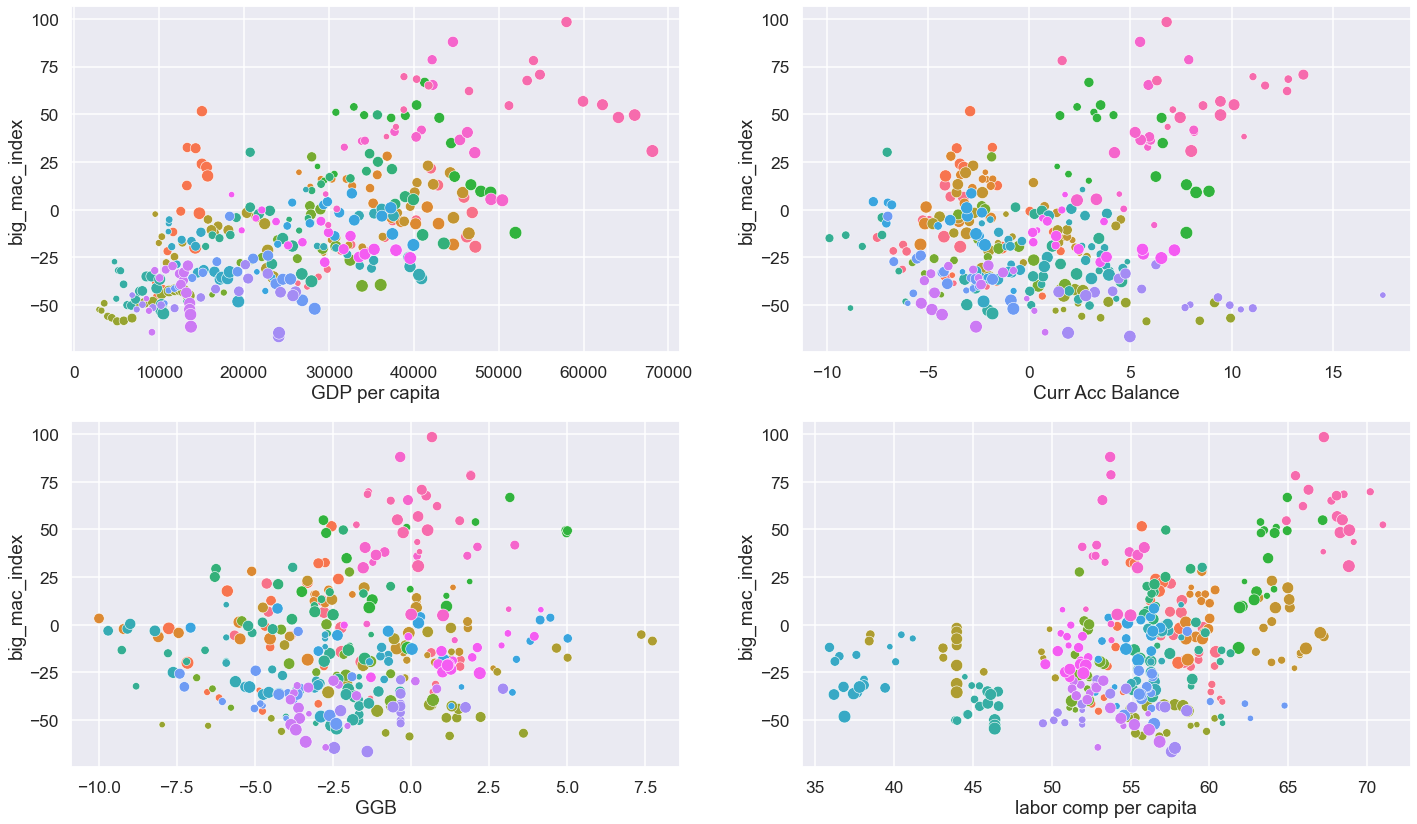

In [15]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (24, 14))

for idx, col in enumerate(['GDP per capita', 'Curr Acc Balance', 'GGB', 'labor comp per capita']):
    plt.sca(ax[idx//2, idx%2])
    sns.scatterplot(data = data.loc[data['iso_a3'] != 'USA'], x = col, y = 'big_mac_index', hue = 'name', size = 'year')
    plt.legend([],[], frameon=False)

### 1. Big Mac Index as a function of GDP

**Although GDP has increased with time across all countries, the price of Big Mac has also increased. Hence, the affordability has decreased.**

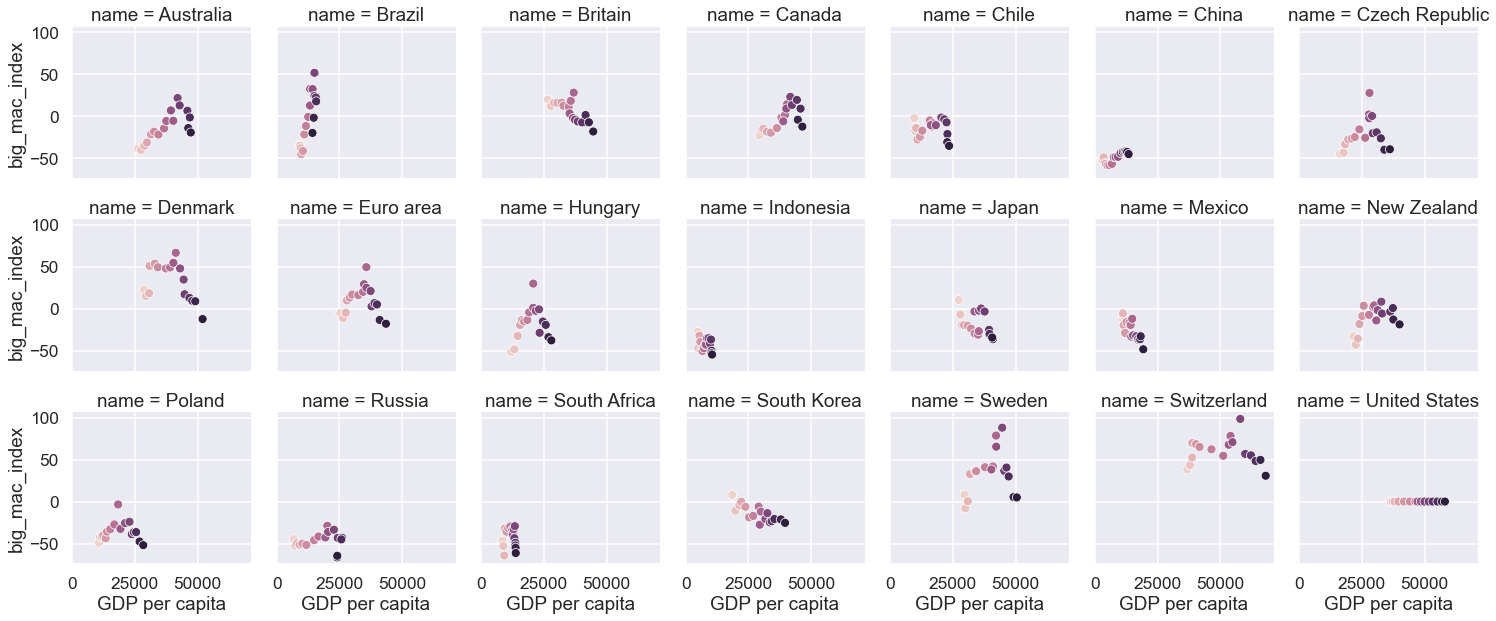

In [39]:
# Big Mac Index v/s GDP with Time

g = sns.FacetGrid(data = data, col = 'name', col_wrap = 7, sharey = True, sharex = True)
g.map(sns.scatterplot, "GDP per capita", "big_mac_index", "year")
plt.show()

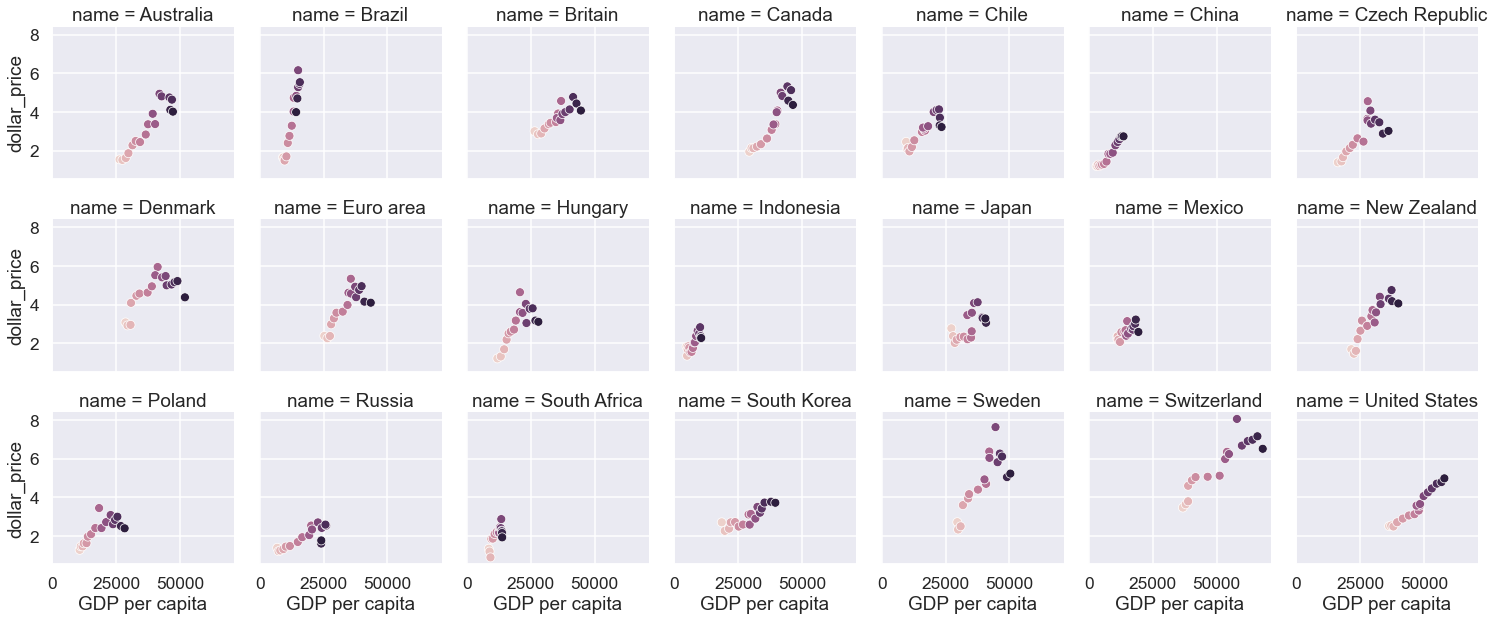

In [40]:
# Big Mac Price v/s GDP with Time

g = sns.FacetGrid(data = data, col = 'name', col_wrap = 7, sharey = True, sharex = True)
g.map(sns.scatterplot, "GDP per capita", "dollar_price", "year")
plt.show()

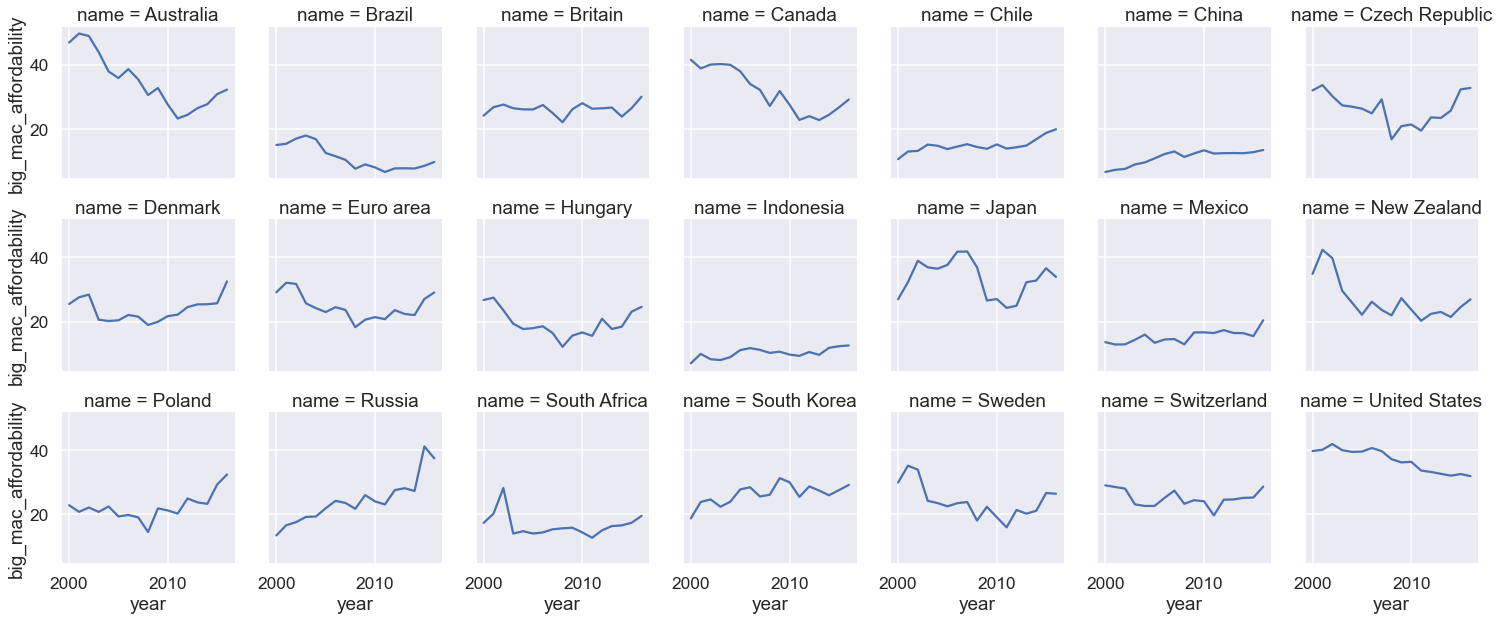

In [43]:
# Big Mac Affordability with Time

g = sns.FacetGrid(data = data, col = 'name', col_wrap = 7, sharey = True, sharex = True)
g.map(sns.lineplot, "year", "big_mac_affordability")
plt.show()

### 2. As a function of Current Account Balance

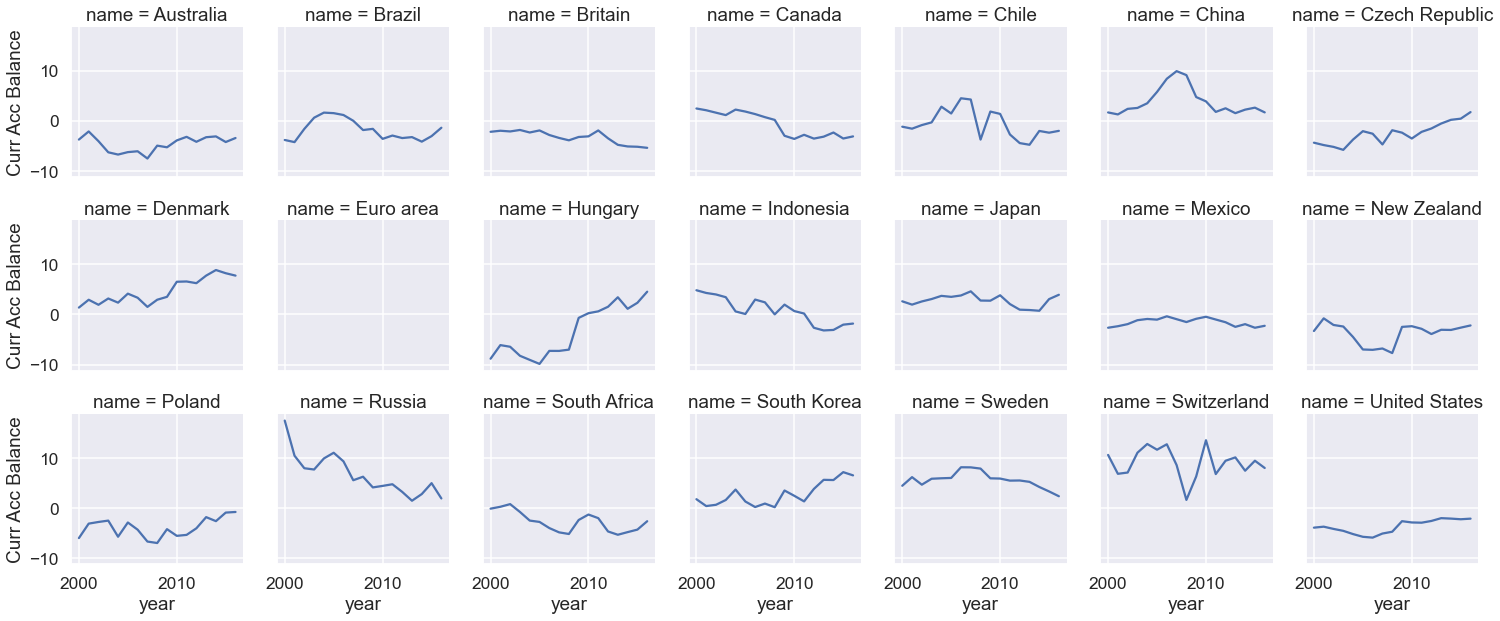

In [49]:
g = sns.FacetGrid(data = data, col = 'name', col_wrap = 7, sharey = True, sharex = True)
g.map(sns.lineplot, "year", "Curr Acc Balance")
plt.show()

### 3. As a function of labor compensation

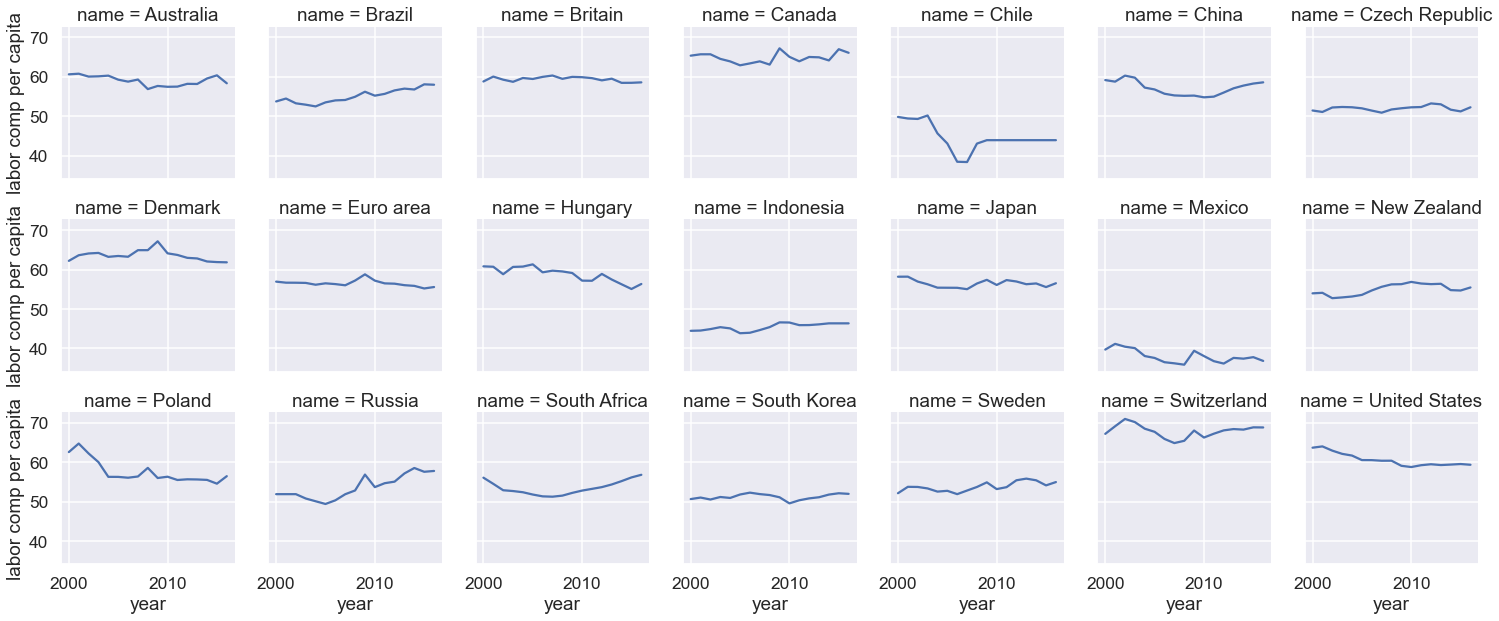

In [58]:
g = sns.FacetGrid(data = data, col = 'name', col_wrap = 7, sharey = True, sharex = True)
g.map(sns.lineplot, "year", "labor comp per capita")
plt.show()

### 4. As a function of General Government Balance

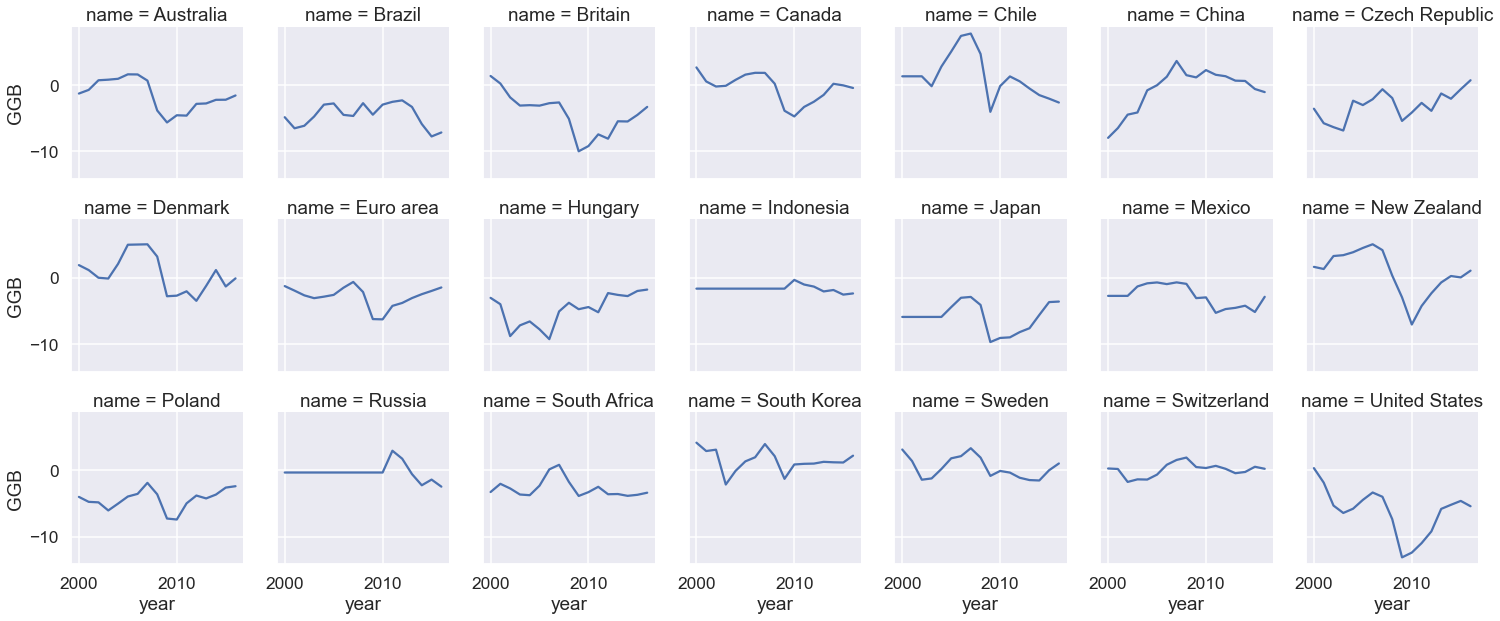

In [59]:
g = sns.FacetGrid(data = data, col = 'name', col_wrap = 7, sharey = True, sharex = True)
g.map(sns.lineplot, "year", "GGB")
plt.show()